# Strain assesment

In the following, we assess the different strain designs using phase plane analysis, quantitative numbers for performance (progesterone yield and growth rate), and visualize one model using Escher.

## Quantitative strains assessment

Three different pathways; pathway 1, the manual obtained, and the combined pathway (Section 02_heterologous_pathway_implementation), were loaded. For each of them models were made containing; the model with no further modification, no NAD(+)/NADPH producing cycling (Section 05_gene_target_analysis), coswap1 (Section 06_co-factor_swap), and combinations of these:

In [24]:
# Load libraries
from cobra.io import read_sbml_model
from cobra import Reaction
from cobra.core.gene import GPR
from matplotlib import pyplot as plt
import numpy as np

In [25]:
# Making models
modelnames = {'':['p'],
              '_manual':['p'],
              '_pathway_combine':['p'],
              '_coswap1':['c',"YJL052W","YJR009C","YGR192C"],
              '_upNAD/NADPH_cycling':["k","YOR120W"]
              }

def making_KOs(model, pkc_list, new_model_name, count):
    tmp_m = model.copy()
    tmp_m.id = model.id + new_model_name
    print(f'Model {count}: {tmp_m.id}')
    count += 1
    for KO in pkc_list[1:]:
        tmp_m.genes.get_by_id(KO).knock_out()
        if tmp_m.genes.get_by_id(KO).functional != False:
            print(f"Error in knocking {tmp_m.genes.get_by_id(KO).name} out in model {tmp_m.id}!")
    return tmp_m, count


def import_reactions(model,infilename):
    with open(infilename,"r") as infile:
        infile.readline()
        for line in infile:
            line = line.rstrip().split(",")
            r = Reaction(line[0])
            r.name = line[2]
            if line[3] != "":
                r.subsystem = line[3]
            r.lower_bound = float(line[4])
            r.upper_bound = float(line[5])
            if line[1] != "":
                r.gpr = GPR.from_string(line[1])
            for i in range(int(len(line[6:])/2)):
                metaboliteID = line[6+i*2]
                if metaboliteID != "":
                    metaboliteID = m.metabolites.get_by_id(metaboliteID)
                    bin = float(line[7+i*2])
                    r.add_metabolites({metaboliteID:bin})
            model.add_reactions([r])
            try:
                model.reactions.get_by_id(r.id)
            except:
                print(f"Error in importing reaction {r} to {model.id}")


print("Making models:")
count = 1
models = {}
for model_p, pkc_id in modelnames.items():
    if pkc_id[0] == "p":
        infilename = "iMM904_progesterone"+model_p
        m_p = read_sbml_model("models/"+infilename+".xml")
        tmp_models = []
        for model_k, pkc_id in modelnames.items():
            if pkc_id[0] == "k":
                tmp_m, count = making_KOs(m_p, pkc_id, "", count)
                models[model_p] = tmp_m
                tmp_models.append(tmp_m)
        m_p.id = infilename + model_k
        print(f"Model {count}: {m_p.id}")
        count += 1
        models[model_p+model_k] = m_p
        tmp_models.append(m_p)
        for m in tmp_models:
            for model_c, pkc_id in modelnames.items():
                if pkc_id[0] == "c":
                    tmp_m, count = making_KOs(m, pkc_id, model_c, count)
                    import_reactions(tmp_m, "data/co-factor_swap_reactions.csv")
                    models[m.id.split(".")[0].split("progesterone")[1] + model_c] = tmp_m



Making models:
Model 1: iMM904_progesterone
Model 2: iMM904_progesterone_upNAD/NADPH_cycling
Model 3: iMM904_progesterone_coswap1
Model 4: iMM904_progesterone_upNAD/NADPH_cycling_coswap1
Model 5: iMM904_progesterone_manual
Model 6: iMM904_progesterone_manual_upNAD/NADPH_cycling
Model 7: iMM904_progesterone_manual_coswap1
Model 8: iMM904_progesterone_manual_upNAD/NADPH_cycling_coswap1
Model 9: iMM904_progesterone_pathway_combine
Model 10: iMM904_progesterone_pathway_combine_upNAD/NADPH_cycling
Model 11: iMM904_progesterone_pathway_combine_coswap1
Model 12: iMM904_progesterone_pathway_combine_upNAD/NADPH_cycling_coswap1


The 12 obtained models were assessed on a phase plane plot:

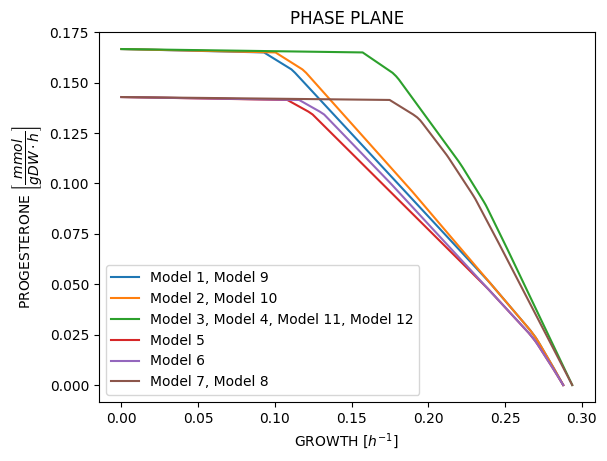

In [26]:
# Phase plane of the models
legends = []
biomass_combined = []
for j, model in enumerate(models.values()):
    with model:
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        max_prog = model.reactions.DM_progesterone_c.flux
        model.objective = model.reactions.BIOMASS_SC5_notrace
        length = 100
        pp = []
        biomass = []
        for i in range(length):
            pp.append((i/(length-1))*max_prog)
            model.reactions.DM_progesterone_c.lower_bound = pp[i]
            biomass.append(round(model.optimize().objective_value,10))
        if biomass not in biomass_combined:
            plt.plot(biomass,pp)
            biomass_combined.append(biomass)
            legends.append("Model "+str(j+1))
        else:
            for k, bio in enumerate(biomass_combined):
                if biomass == bio:
                    legends[k] += ", Model "+str(j+1)

plt.legend(legends)
plt.xlabel(r"GROWTH $\left[h^{-1}\right]$")
plt.ylabel(r"PROGESTERONE $\left[\dfrac{mmol}{gDW\cdot h}\right]$")
plt.title("PHASE PLANE")
plt.savefig('figures/08_strain_assessment_phase_plan_plot.png',bbox_inches='tight')
plt.show()

From the plot above we see that model 3, 4, 11, and 12 have the best performance. These models all have implemented the co-factor swap modification (section 06_co-factor_swap). Therefore, this modification seems to be important to get a high performing model. Interestingly, by removing NAD(+)/NADPH cycling (model 4 and 12; section 05_knockout_analysis) there are no change in the phase plane. This suggests that the co-factor swapping takes over the role that NAD(+)/NADPH cycling has. 
Models with the manually derived pathway (model 5-8) follow the same trends that for the other pathways, but with a lower maximum progesterone productivity.  

In [35]:
# printing stats of models
number_of_modifications = [4,8,8,12,4,8,8,12,8,12,12,16]
model_score = {}
combined = []
for i, (name, model) in enumerate(models.items()):
    with model:
        combined.append([number_of_modifications[i]])
        model_score[name] = []
        model.objective = model.reactions.BIOMASS_SC5_notrace
        model.optimize()
        max_bio = model.reactions.BIOMASS_SC5_notrace.flux
        model_score[name][i].append(max_bio)
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        max_prog = model.reactions.DM_progesterone_c.flux
        model_score[name][i].append(max_prog*(-1)/model.reactions.EX_glc__D_e.flux)
        model.objective = {model.reactions.BIOMASS_SC5_notrace: max_prog,
                           model.reactions.DM_progesterone_c: max_bio}
        model.optimize()
        model_score[name][i].extend([model.reactions.BIOMASS_SC5_notrace.flux,
                            model.reactions.DM_progesterone_c.flux*(-1)/model.reactions.EX_glc__D_e.flux])
        model.reactions.BIOMASS_SC5_notrace.lower_bound = 0.18
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        model_score[name][i].append(model.reactions.DM_progesterone_c.flux*(-1)/model.reactions.EX_glc__D_e.flux)
        combined.extend(model_score[name][i])
print("Model number\tModifications\t Max µ \t\t Max progesterone yield \t Optimized µ\t Optimized progesterone yield\t Progesterone yield at µ=0.18\tScore")
extra = "\t"
print(combined)
for i in range(len(combined)):
    max = np.max(np.array(combined[:,i]))
    min = np.min(np.array(combined[:,i]))
    print(max,min)

for i, values in enumerate(model_score.values()):
    if i > 8:
        extra = ""
    print(f"Model {i+1}\t"+extra,str(number_of_modifications[i]),"\t\t",str(round(values[0],5)),"/h\t",str(round(values[1],5)),"mmol/mmol\t\t",str(round(values[2],5)),"/h\t",str(round(values[3],5)),"mmol/mmol\t\t",str(round(values[4],5)),"mmol/mmol")


IndexError: list index out of range

In [17]:
# modelnames = {'':['p'],
#               '_manual':['p'],
#               '_pathway_combine':['p'],
#               '_coswap1':['c',"YJL052W","YJR009C","YGR192C"],
#               '_noNAD/NADPH_cycling':["k","YOR120W"]}
    
    # names.append()
for i, values in enumerate(model_score.values()):
    print("| Model",str(i+1),"|","","|"," | ".join([str(round(x,4)) for x in values]),"|")

| Model 1 |  | 0.2879 | 0.0167 | 0.1187 | 0.0156 | 0.0104 |
| Model 2 |  | 0.2879 | 0.0167 | 0.1113 | 0.0156 | 0.01 |
| Model 3 |  | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 4 |  | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 5 |  | 0.2879 | 0.0143 | 0.1313 | 0.0135 | 0.0096 |
| Model 6 |  | 0.2879 | 0.0143 | 0.1237 | 0.0135 | 0.0092 |
| Model 7 |  | 0.2937 | 0.0143 | 0.1919 | 0.0133 | 0.0139 |
| Model 8 |  | 0.2937 | 0.0143 | 0.1919 | 0.0133 | 0.0139 |
| Model 9 |  | 0.2879 | 0.0167 | 0.1187 | 0.0156 | 0.0104 |
| Model 10 |  | 0.2879 | 0.0167 | 0.1113 | 0.0156 | 0.01 |
| Model 11 |  | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 12 |  | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |


## Metabolic pathway visualisations using Escher

The addition or deletion of genes, e.g., when implementing a heterologous pathway, will change the normal flux balances. Online programs like Escher can be used for visualisation of these changes.

### Visualised fluxes on central carbon metabolism map

In [ ]:
# Load relevant packages
from IPython.display import Image
import escher
import pandas
import cobra

In [ ]:
coswap_model = models["_coswap1"]

In [ ]:
escher.list_available_maps() # see available maps in escher

It can be seen that the only available map for *Saccharomyces cerevisiae* is the iMM904 central carbon metabolism. When implementing out heterologous pathway, the normally occuring fluxes are altered; The alterations on the central carbon metabolism can be visulased using Escher on the available map in *S. cerevisiae*.

In [ ]:
model = read_sbml_model('models/iMM904_progesterone.xml') # Load model
model.objective = model.reactions.R02216 
solution = model.optimize() # simulate model
fluxes = solution.fluxes

In [ ]:
escher.Builder('iMM904.Central carbon metabolism',
               reaction_data=fluxes.to_dict()) # Adding our fluxes to the iMM904 model and watch how they change - the map is saved as a figure 

### Visualisation of heterologous pathway and fluxes

In [ ]:
model = read_sbml_model('models/iMM904_progesterone.xml') # Load model
model.objective = model.reactions.R02216 # set objective to progesterone production
solution = model.optimize() # simulate model
fluxes = solution.fluxes.to_csv("flux.csv") # save simulated fluxes as csv file that can be uploaded to the online version of escher